In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot
import os
from copy import deepcopy


from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson
import scipy.sparse as sp
from scipy.io import mmread

from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available
import importlib
import sys
import umap


/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from DeepOMAPNet.Preprocess import prepare_train_test_anndata

data = prepare_train_test_anndata()

All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

In [3]:
data

(AnnData object with n_obs × n_vars = 158179 × 36601
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source'
     obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 46922 × 36601
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source'
     obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
     layers: 'counts',
 AnnData object with 

In [3]:
trainADT = data[2]
trainADT

AnnData object with n_obs × n_vars = 158179 × 279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'sample', 'occupancy_score', 'source'
    layers: 'counts'

In [4]:
import scanpy as sc
import scanpy.external as sce  #

sc.pp.normalize_total(trainADT, target_sum=1e4)   # library-size normaliz
sc.pp.log1p(trainADT)

sc.pp.scale(trainADT, max_value=10)
sc.tl.pca(trainADT, n_comps=50, svd_solver="arpack")

sce.pp.bbknn(
    trainADT,
    batch_key='samples',
    n_pcs=50,
    neighbors_within_batch=3,
    trim=0
)



/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
consider updating your call to make use of `computation`


/var/tmp/ipykernel_3366683/3653598042.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(trainADT, resolution=1.0)


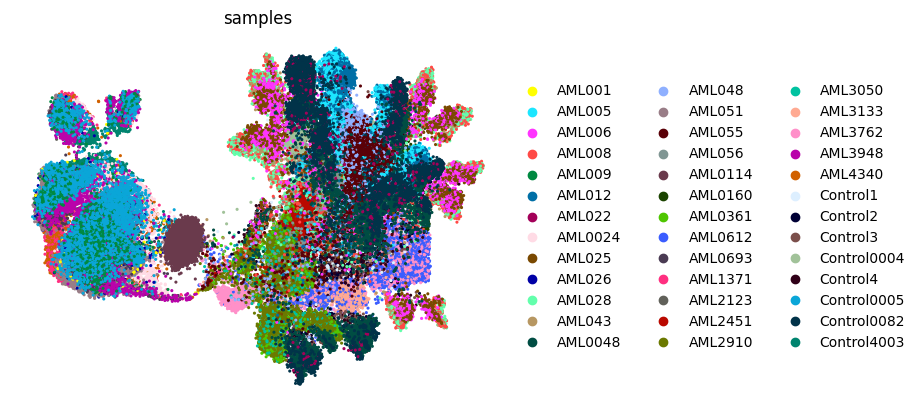

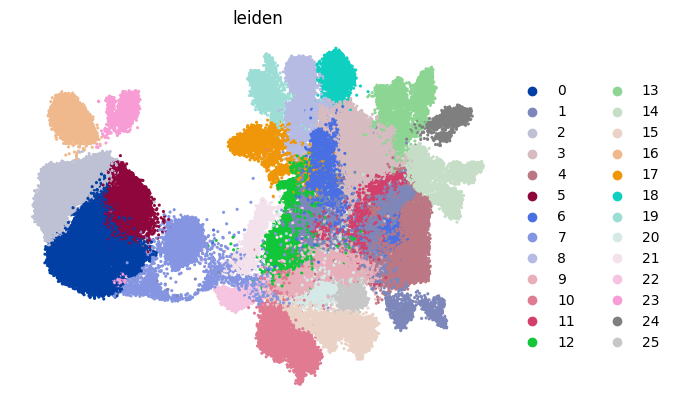

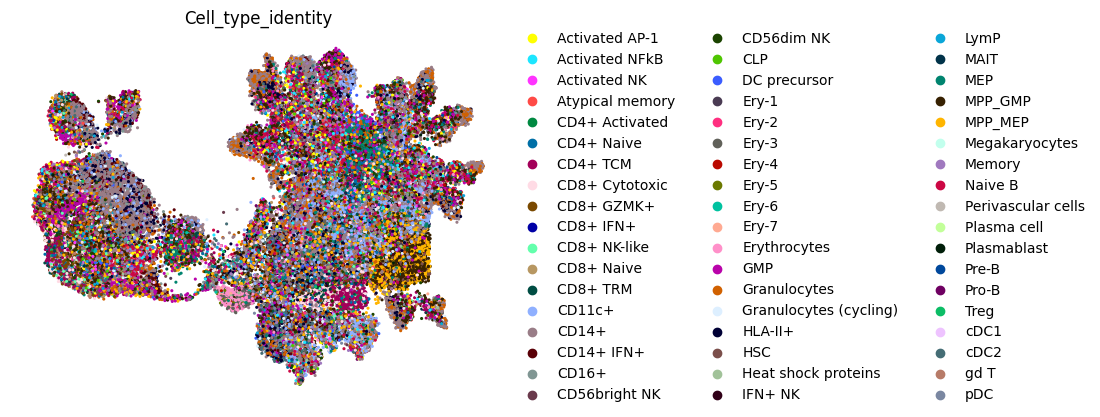

In [5]:

sc.tl.umap(trainADT)

# 4) (Optional) Leiden clustering
sc.tl.leiden(trainADT, resolution=1.0)

# 5) Visualize mixing & clusters
sc.pl.umap(
    trainADT,
    color=['samples'],
    wspace=0.4,
    size=20,
    frameon=False
)

sc.pl.umap(
    trainADT,
    color=['leiden'],
    wspace=0.4,
    size=20,
    frameon=False
)

sc.pl.umap(
    trainADT,
    color=['Cell_type_identity'],
    wspace=0.4,
    size=20,
    frameon=False
)


In [7]:
trainADT

AnnData object with n_obs × n_vars = 158179 × 279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'sample', 'occupancy_score', 'source'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [6]:
# 2) compute the three requested quantities
num_graphs   = 1                                 # single k‑NN graph
num_features = trainADT.X.shape[1]                        # feature dimension
num_classes  = trainADT.obs["leiden"].nunique() # distinct Leiden clusters

print(f"Number of graphs:   {num_graphs}")
print(f"Number of features: {num_features}")
print(f"Number of classes:  {num_classes}")

Number of graphs:   1
Number of features: 279
Number of classes:  26


In [7]:


# assumes you have already run sc.pp.neighbors / BBKNN on `trainGene`
A = trainADT.obsp["connectivities"]            # sparse adjacency
num_nodes = trainADT.n_obs

# --- edge count ----------------------------------------------------------
# If the graph is undirected (A == A.T), each edge is stored twice
is_undirected = (A != A.T).nnz == 0
diag_nnz      = A.diagonal().nonzero()[0].size  # possible self‑loops
if is_undirected:
    num_edges = (A.nnz - diag_nnz) // 2 + diag_nnz
else:
    num_edges = A.nn

avg_deg = num_edges / num_nodes

# --- training mask -------------------------------------------------------
# If you stored a boolean mask in .obs, use it – otherwise treat *all* nodes as training
train_mask = (
    trainADT.obs["train_mask"].to_numpy()
    if "train_mask" in trainADT.obs
    else np.ones(num_nodes, dtype=bool)
)
num_train_nodes  = train_mask.sum()
train_label_rate = num_train_nodes / num_nodes

# --- graph diagnostics ---------------------------------------------------
has_isolated = (A.sum(axis=1).A1 == 0).any()
has_selfloops = diag_nnz > 0

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average node degree: {avg_deg:.2f}")
print(f"Number of training nodes: {num_train_nodes}")
print(f"Training node label rate: {train_label_rate:.2f}")
print(f"Has isolated nodes: {has_isolated}")
print(f"Has self-loops: {has_selfloops}")
print(f"Is undirected: {is_undirected}")


Number of nodes: 158179
Number of edges: 18136769
Average node degree: 114.66
Number of training nodes: 158179
Training node label rate: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()
/var/tmp/ipykernel_3366683/734318210.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_labels))


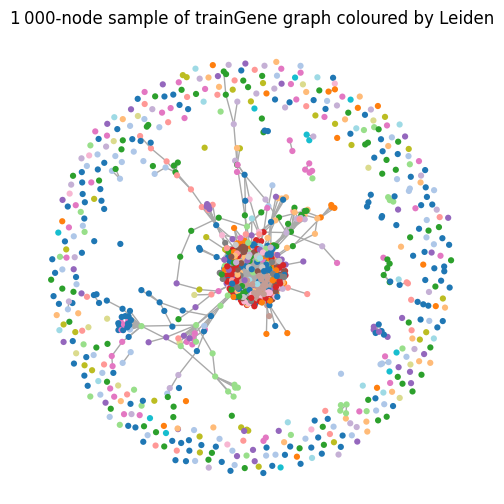

In [8]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

# -------------------------------------------------------------------------
# 1) pick node features and labels
# -------------------------------------------------------------------------
X = (
    trainADT.obsm["X_integrated.cca"]
    if "X_integrated.cca" in trainADT.obsm
    else trainADT.obsm["X_pca"]
)
y = trainADT.obs["leiden"].astype(int).to_numpy()

# -------------------------------------------------------------------------
# 2) build edge index from Scanpy connectivities
# -------------------------------------------------------------------------
A = trainADT.obsp["connectivities"].tocsr()              # guaranteed CSR
# keep only upper‑triangle to avoid duplicate edges
A_triu = sparse.triu(A, k=1)
row, col = A_triu.nonzero()
edge_index = torch.tensor(np.vstack([row, col]), dtype=torch.long)

# -------------------------------------------------------------------------
# 3) assemble PyG Data
# -------------------------------------------------------------------------
data = Data(
    x=torch.tensor(X, dtype=torch.float32),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long),
)

# -------------------------------------------------------------------------
# 4) convert to NetworkX
# -------------------------------------------------------------------------
G_full = to_networkx(data, to_undirected=True)

# -------------------------------------------------------------------------
# 5) visualise a 1 000‑node induced sub‑graph for clarity
# -------------------------------------------------------------------------
np.random.seed(0)
subset = np.random.choice(data.num_nodes, size=1_000, replace=False)
G_sub = G_full.subgraph(subset)

# map Leiden labels to colours
labels_sub = {i: int(data.y[i]) for i in subset}
unique_labels = sorted(set(labels_sub.values()))
cmap = plt.cm.get_cmap("tab20", len(unique_labels))
node_colors = [cmap(labels_sub[n]) for n in G_sub.nodes]

plt.figure(figsize=(6, 6))
nx.draw_networkx(
    G_sub,
    pos=nx.spring_layout(G_sub, seed=1),
    node_size=20,
    node_color=node_colors,
    with_labels=False,
    edge_color="#AAAAAA",
    linewidths=0.0,
)
plt.axis("off")
plt.title("1 000‑node sample of trainGene graph coloured by Leiden")
plt.show()


In [10]:
# -------------------------------------------------------------------------
# Use the `data` object you built from trainGene (features = embedding,
# labels = Leiden). We add train/val/test masks and adapt the MLP training.
# -------------------------------------------------------------------------
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.nn import GATConv
import torch.nn.functional as F

# ----- create train/val/test masks (stratified by Leiden labels) ----------
N = data.num_nodes
y_np = data.y.cpu().numpy()

# first split train vs temp (train_frac = 0.8)
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(np.zeros(N), y_np))

# split temp into val/test 50/50 → 10% each of total
y_temp = y_np[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=43)
val_rel, test_rel = next(sss2.split(np.zeros(len(temp_idx)), y_temp))
val_idx  = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

train_mask = torch.zeros(N, dtype=torch.bool)
val_mask   = torch.zeros(N, dtype=torch.bool)
test_mask  = torch.zeros(N, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

print(
    f"Split sizes → train: {train_mask.sum().item()} | "
    f"val: {val_mask.sum().item()} | test: {test_mask.sum().item()}"
)


in_dim  = data.x.size(1)
n_class = int(data.y.max().item() + 1)



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_dim, hidden_channels)  # TODO
        self.conv2 = GATConv(hidden_channels, n_class)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=8, heads=8).to(device)
data = data.to(device)  
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

for epoch in range(1, 501):
    loss = train()
    
    if epoch % 10 == 0 or epoch == 1:
        val_acc = test(data.val_mask)
        test_acc = test(data.test_mask)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



Split sizes → train: 126543 | val: 15818 | test: 15818
GAT(
  (conv1): GATConv(50, 8, heads=1)
  (conv2): GATConv(8, 26, heads=1)
)
Epoch: 001, Loss: 8.5140, Val: 0.0514, Test: 0.0514
Epoch: 010, Loss: 3.6877, Val: 0.0465, Test: 0.0469
Epoch: 020, Loss: 3.3880, Val: 0.0226, Test: 0.0236
Epoch: 030, Loss: 3.2454, Val: 0.0363, Test: 0.0362
Epoch: 040, Loss: 3.2231, Val: 0.0554, Test: 0.0549
Epoch: 050, Loss: 3.0754, Val: 0.0690, Test: 0.0709
Epoch: 060, Loss: 2.9081, Val: 0.0906, Test: 0.0898
Epoch: 070, Loss: 2.8732, Val: 0.0914, Test: 0.0925
Epoch: 080, Loss: 2.7753, Val: 0.1226, Test: 0.1226
Epoch: 090, Loss: 2.7472, Val: 0.1287, Test: 0.1278
Epoch: 100, Loss: 2.7073, Val: 0.1314, Test: 0.1304
Epoch: 110, Loss: 2.6392, Val: 0.1218, Test: 0.1240
Epoch: 120, Loss: 2.6589, Val: 0.1234, Test: 0.1254
Epoch: 130, Loss: 2.5367, Val: 0.1219, Test: 0.1242
Epoch: 140, Loss: 2.5416, Val: 0.1228, Test: 0.1247
Epoch: 150, Loss: 2.4808, Val: 0.1216, Test: 0.1218
Epoch: 160, Loss: 2.5009, Val: 0.144